### Example with DataLinks and LinkProbability class
Testing a way to measure scores from co-occurences in the data.

In [17]:
import sys
sys.path.append('/Users/simon/git/lda/code')

# data locations
# DATASET = "/Users/simon/carnegie/data/"
# PATH_MGF_DATA = s/"
MIBIG_JSON_DIR = "/Users/simon/Desktop/carnegie_bigscape/mibig/mibig_json-1.4/"
# PATH_MS2LDA = DATASET

# annotations
NODES_FILE = "/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/carnegie_gnps_data/ProteoSAFe-METABOLOMICS-SNETS-2cdc2aa3-download_clustered_spectra-2/clusterinfosummarygroup_attributes_withIDs_withcomponentID/reformated_derep.tsv"
DEREP_ANNOTATIONS = "/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/carnegie_gnps_data/cluster_to_derep.tsv"

MGF_FILE = "/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/carnegie_gnps_data/ProteoSAFe-METABOLOMICS-SNETS-2cdc2aa3-download_clustered_spectra-2/METABOLOMICS-SNETS-2cdc2aa3-download_clustered_spectra-main.mgf"
EDGES_FILE = "/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/carnegie_gnps_data/ProteoSAFe-METABOLOMICS-SNETS-2cdc2aa3-download_clustered_spectra-2/networkedges_selfloop/1eca77da22c84ae1aee490d0e4bc26f3.pairsinfo"

FOLDERS = ['NRPS','Others','PKSI','PKS-NRP_Hybrids','PKSother','RiPPs','Saccharides','Terpene']
FOLDERS = ['NRPS']
# GCF file path
ROOT_PATH = "/Users/simon/Desktop/carnegie_bigscape/bigscape-carnegie-glocal/network_files/2018-11-16_12-01-18_hybrids_glocal/"
ANTISMASH_DIR = "/Users/simon/Desktop/carnegie_bigscape/antismash/"

from nplinker_constants import nplinker_setup
# nplinker_setup(LDA_PATH=PATH_MS2LDA)

In [18]:
# import from NPlinker
from metabolomics import load_spectra
from metabolomics import load_metadata
from metabolomics import load_edges
from metabolomics import make_families
from genomics import loadBGC_from_cluster_files
from genomics import make_mibig_bgc_dict

from data_linking import DataLinks
from data_linking import LinkLikelihood
from data_linking import LinkFinder

# import general packages
import os
import glob



In [68]:
# load, initialize data
# nplinker_setup(LDA_PATH=PATH_MS2LDA)

spectra = load_spectra(MGF_FILE)
for s in spectra:
    s.annotation_from_metadata()
load_edges(spectra, EDGES_FILE)
families = make_families(spectra)
metadata = load_metadata(spectra, NODES_FILE)

input_files = []
ann_files = []
mibig_bgc_dict = make_mibig_bgc_dict(MIBIG_JSON_DIR)

for folder in FOLDERS:
    print("Processing subfolder %s" % folder, end='')
    fam_file = os.path.join(ROOT_PATH, folder)
    if os.path.exists(fam_file):
        print("")
        cluster_file = glob.glob(fam_file + os.sep + folder + "_clustering*75*")
        annotation_files = glob.glob(fam_file + os.sep + "Network_*")
        #print(cluster_file[0])
        #print(annotation_files[0])
        input_files.append(cluster_file[0])
        ann_files.append(annotation_files[0])
    else:
        print(" - not found")
gcf_list, bgc_list, strain_list = loadBGC_from_cluster_files(input_files, ann_files, antismash_dir=ANTISMASH_DIR, antismash_format = 'flat', mibig_bgc_dict=mibig_bgc_dict)

Loaded 3125 molecules
Found 1816 MiBIG json files
Processing subfolder NRPS


In [231]:
%load_ext autoreload
%autoreload 2
from scoring import metcalf_scoring
gcf = list(filter(lambda x: str(x) == "NRPS_clustering_c0.75.tsv:1902",gcf_list))[0]
ms = []
for s in spectra:
    ms.append(metcalf_scoring(s,gcf,strains = strain_list[1:],neither=1))
print(len(ms))
print(gcf_list.index(gcf))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3125
72


In [252]:
from data_linking import DataLinks,LinkFinder,RandomisedDataLinks
data_links = DataLinks()
data_links.load_data(spectra, gcf_list, strain_list[1:])
data_links.find_correlations(include_singletons=False)
l = LinkFinder()
ms = l.metcalf_scoring(data_links)
print(l.metcalf_spec_gcf.shape)
eg_scores = l.metcalf_spec_gcf[:,72]

pos = data_links.get_spec_pos(spectra[0].spectrum_id)
print(pos)

Create mappings between spectra, gcfs, and strains.
Create co-occurence matrices: spectra<->strains + and gcfs<->strains.
Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

(3125, 76)
0


In [253]:
rdata_links = RandomisedDataLinks.from_datalinks(data_links)
rdata_links.find_correlations(include_singletons=False)
rms = l.metcalf_scoring(rdata_links)

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf



23.0


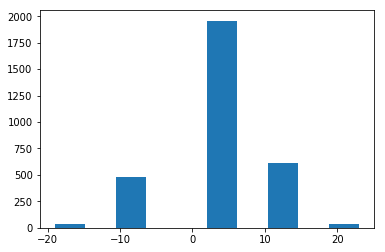

In [259]:
plt.hist(rms[:,72])
print(rms[:,72].max())

In [286]:
from process_output import get_sig_links,get_sig_spec
sig_links = get_sig_links(ms,rms,direction = 'greater',p_threshold=1.0)
for i,g in enumerate(gcf_list):
    orig_ids = get_sig_spec(data_links,sig_links,ms,i,min_n_strains = 2)
    if len(orig_ids) > 0:
        print(orig_ids)



[(53, 23.0), (233, 23.0), (353, 23.0), (374, 23.0), (436, 23.0), (576, 23.0), (658, 23.0), (732, 23.0), (811, 23.0), (836, 23.0), (853, 23.0), (874, 23.0), (912, 23.0), (966, 23.0), (990, 23.0), (1018, 23.0), (1041, 23.0), (1049, 23.0), (1105, 23.0), (1124, 23.0), (1129, 23.0), (1131, 23.0), (1194, 23.0), (1213, 23.0), (1223, 23.0), (1340, 23.0), (1352, 23.0), (1366, 23.0), (1508, 23.0), (1597, 23.0), (1598, 23.0), (1633, 23.0), (1658, 23.0), (1683, 23.0), (1754, 23.0), (1810, 23.0), (1817, 23.0), (1827, 23.0), (1830, 23.0), (1853, 23.0), (1854, 23.0), (1855, 23.0), (1865, 23.0), (1948, 23.0), (1951, 23.0), (2029, 23.0), (2134, 23.0)]
[(374, 24.0)]
[(374, 24.0)]
[(374, 24.0)]
[(374, 24.0)]
[(961, 33.0), (962, 33.0), (33, 23.0), (36, 23.0), (149, 23.0), (234, 23.0), (256, 23.0), (374, 23.0), (376, 23.0), (441, 23.0), (473, 23.0), (474, 23.0), (475, 23.0), (491, 23.0), (497, 23.0), (498, 23.0), (499, 23.0), (500, 23.0), (502, 23.0), (504, 23.0), (506, 23.0), (512, 23.0), (513, 23.0), (51

In [267]:
print(sig_links.sum())
print(np.array(sig_links.shape).prod())

2.0
237500


In [251]:
spec_pos = 960
pos = data_links.get_spec_pos(spectra[spec_pos].spectrum_id)
# print(ms[spec_pos],eg_scores[pos])
print(strain_list[1:])
for strain in strain_list[1:]:
    print(spectra[spec_pos].has_strain(strain))
    
print(data_links.M_spec_strain[pos,:])
print(data_links.map_strain_name)


print(data_links.M_gcf_strain[72,:])
print(data_links.M_spec_gcf[pos,72])
print(data_links.M_notspec_notgcf[pos,72])
print(data_links.M_spec_notgcf[pos,72])
print(data_links.M_notspec_gcf[pos,72])
print(metcalf_scoring(spectra[961],gcf_list[72],strain_list[1:]))
print(ms[961,72])

['KRD026', 'KRD162', 'KRD171', 'KRD175', 'KRD197', 'KRD202']
False
True
False
True
True
False
[0. 1. 0. 1. 1. 0.]
['KRD026', 'KRD162', 'KRD171', 'KRD175', 'KRD197', 'KRD202']
[0. 1. 0. 1. 1. 0.]
3.0
3.0
0.0
0.0
(33, {'KRD197', 'KRD175', 'KRD162'})
27.0


In [49]:
print(strain_list)

['MiBIG', 'KRD026', 'KRD162', 'KRD171', 'KRD175', 'KRD197', 'KRD202']


In [61]:
s = list(filter(lambda x: x.family.family_id == '121',spectra))
f = list(filter(lambda x: x.family_id == '121',families))[0]
from scoring import metcalf_scoring
ms = metcalf_scoring(f,gcf,strains=strain_list[1:])
mss = []
for ss in s:
    print(ss.spectrum_id)
    mss.append(metcalf_scoring(ss,gcf,strains=strain_list[1:]))
print(ms)
print(mss)

497
498
499
500
501
502
504
505
506
507
508
509
510
511
513
514
515
516
518
519
520
521
522
523
524
525
528
530
537
540
546
548
549
559
(23, {'KRD197', 'KRD175'})
[(23, {'KRD197', 'KRD175'}), (23, {'KRD197', 'KRD175'}), (23, {'KRD197', 'KRD175'}), (23, {'KRD197', 'KRD175'}), (3, set()), (23, {'KRD197', 'KRD175'}), (23, {'KRD197', 'KRD175'}), (3, set()), (23, {'KRD197', 'KRD175'}), (13, {'KRD197'}), (3, set()), (3, set()), (3, set()), (13, {'KRD175'}), (23, {'KRD197', 'KRD175'}), (13, {'KRD197'}), (3, set()), (13, {'KRD175'}), (23, {'KRD197', 'KRD175'}), (3, set()), (13, {'KRD197'}), (13, {'KRD175'}), (3, set()), (3, set()), (3, set()), (13, {'KRD197'}), (3, set()), (3, set()), (13, {'KRD197'}), (3, set()), (13, {'KRD197'}), (3, set()), (13, {'KRD197'}), (13, {'KRD197'})]


In [20]:
# extract relevant linking mappings calculate co-occurences
data_links = DataLinks()
data_links.load_data(spectra, gcf_list, strain_list)
data_links.find_correlations(include_singletons=False)

Create mappings between spectra, gcfs, and strains.
Create co-occurence matrices: spectra<->strains + and gcfs<->strains.
Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf
  Done  76  of  76  type2s
  Done  3125  of  3125  type1s.

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf
  Done  76  of  76  type2s
  Done  349  of  349  type1s.



In [21]:
# Calculate link probabilities, such as:
# P(gcf_x | spec_y) = probability to find gcf_x in a strain, given spec_y is present
# P(gcf_x | not spec_y) = probability to find gcf_x in a strain, given spec_y is NOT present 
likelihoods = LinkLikelihood()
likelihoods.calculate_likelihoods(data_links, type='spec-gcf')
likelihoods.calculate_likelihoods(data_links, type='fam-gcf')

Calculating likelihood matrices of type:  spec-gcf
Calculating likelihood matrices of type:  fam-gcf


### Select potential link candidates
#### Search for links between GCFs and spectra, and between GCFs and mol. families
Can now be done using the metcalf score or based on the likelihood ("likelihood score"). 

In [10]:
linkcandidates = LinkFinder()

linkcandidates.metcalf_scoring(data_links,
                        both=10, 
                        type1_not_gcf=-10, 
                        gcf_not_type1=0,
                        type='spec-gcf')

linkcandidates.metcalf_scoring(data_links,
                        both=10, 
                        type1_not_gcf=-10, 
                        gcf_not_type1=0,
                        type='fam-gcf')

array([[-20., -20., -20., ..., -20., -20., -20.],
       [-40., -40., -40., ..., -20., -40., -40.],
       [-20., -20., -20., ...,   0., -20., -20.],
       ...,
       [-40., -40., -40., ..., -20., -40., -40.],
       [-40., -40., -40., ..., -20., -40., -40.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

Here is the second type of score(the one I had used before). Like the metcalf score it takes into account the directionality BGC-->compound-->spectrum, which suggests that the most relevant likelihoods are: 

P(gcf|type1) - If type1 is the result of only one particular gene cluster,
                            this value should be high (close or equal to 1)

P(type1|not gcf) - Following the same logic, this value should be very 
                                small or 0 ("no gene cluster, no compound") P(gcf_x | spec_y).
                                
This is then weighted by the number of strains this co-occurence was found in.

In [11]:
linkcandidates.likelihood_scoring(data_links, likelihoods, 
                        alpha_weighing=0.5,
                        type='spec-gcf')

linkcandidates.likelihood_scoring(data_links, likelihoods, 
                        alpha_weighing=0.5,
                        type='fam-gcf')

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03934693, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.15738774, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03934693, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03934693, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Using those scores it is then possible to select suitable, promising candidates for potential links between spectra and GCFs, or mol.families and GCFs.

In [12]:
link_candidates_spec = linkcandidates.select_link_candidates(data_links, likelihoods,
                               P_cutoff=0.9, 
                               main_score='likescore',
                               score_cutoff=0.6, 
                               type='spec-gcf')

link_candidates_fam = linkcandidates.select_link_candidates(data_links, likelihoods,
                               P_cutoff=0.8, 
                               main_score='likescore',
                               score_cutoff=0, 
                               type='fam-gcf')

38  candidates selected with  P(gcf|spec)  >=  0.9  and a link score >=  0.6 .
177  candidates selected with  P(gcf|fam)  >=  0.8  and a link score >=  0 .


What becomes apparent is that the score I used and metcalf are indeed very similar in the sense that they nearly sort candidates the same way. The score I use here ("likescore"or "likelihood score") might have the advantage that it is normalized to (0,1). 

In [13]:
# Show table of potential gcf<-> spectrum link candidates
#link_candidates_fam.head()
link_candidates_fam.nlargest(10, 'likelihood score')

,family_id,GCF id,P(gcf|fam),P(fam|gcf),P(gcf|not fam),P(fam|not gcf),co-occur in # strains,metcalf score,likelihood score,BGC class
0,2.0,66.0,1.0,0.666667,0.200000,0.0,2.0,20.0,0.632121,Others
2,16.0,66.0,1.0,0.666667,0.200000,0.0,2.0,20.0,0.632121,Others
77,157.0,66.0,1.0,0.666667,0.200000,0.0,2.0,20.0,0.632121,Others
103,217.0,66.0,1.0,0.666667,0.200000,0.0,2.0,20.0,0.632121,Others
140,299.0,66.0,1.0,0.666667,0.200000,0.0,2.0,20.0,0.632121,Others
154,323.0,66.0,1.0,0.666667,0.200000,0.0,2.0,20.0,0.632121,Others
164,327.0,66.0,1.0,0.666667,0.200000,0.0,2.0,20.0,0.632121,Others
174,339.0,66.0,1.0,0.666667,0.200000,0.0,2.0,20.0,0.632121,Others
175,340.0,66.0,1.0,0.666667,0.200000,0.0,2.0,20.0,0.632121,Others
1,12.0,66.0,1.0,0.333333,0.333333,0.0,1.0,10.0,0.393469,Others


In [14]:
from data_linking import RandomisedDataLinks

# create DataLinks object and load_data as normal
data_links = DataLinks()
data_links.load_data(spectra, gcf_list, strain_list)

# now create the randomised version from the existing object
rdata_links = RandomisedDataLinks.from_datalinks(data_links)

# now generate other matrices as normal
data_links.find_correlations(include_singletons=False)
rdata_links.find_correlations(include_singletons=False)

testlf = LinkFinder()
# generate metcalf scores for spec-gcf mode for both standard and random datalinks
metcalf_scores = testlf.metcalf_scoring(data_links, type='spec-gcf')
rand_metcalf_scores =  testlf.metcalf_scoring(rdata_links, type='spec-gcf')

Create mappings between spectra, gcfs, and strains.
Create co-occurence matrices: spectra<->strains + and gcfs<->strains.
Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf
  Done  76  of  76  type2s
  Done  3125  of  3125  type1s.

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf
  Done  76  of  76  type2s
  Done  349  of  349  type1s.

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf
  Done  76  of  76  type2s
  Done  3125  of  3125  type1s.

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf
  Done  76  of  76  type2s
  Done  349  of  349  type1s.



In [15]:
import numpy as np


def test_export(gcf_list, spectra_list, metcalf_scores, filtered_scores):
    import networkx as nx
    NPlinker_net = nx.Graph() 
    
    spectra_node_list = set()
    gcf_node_list = []
    gcf_indices = {}
    
    # Add nodes corresponding to spectra with bipartite=0
    # Add nodes corresponding to GCFs with bipartite=1
    for (i, indices) in filtered_scores:
        gcf_node_list.append(i)
        gcf_indices[i] = len(gcf_node_list) - 1
        spectra_node_list.update(map(str, [spectra[x] for x in indices]))
        
    spectra_node_list = list(spectra_node_list)
    NPlinker_net.add_nodes_from(spectra_node_list, bipartite=0)
    NPlinker_net.add_nodes_from(gcf_node_list, bipartite=1) 
    
    # want to add edges between GCFs and spectra given in indices
    edges_added = 0
    for (i, indices) in filtered_scores:
        for j in range(len(indices)):
            edges_added += 1
            NPlinker_net.add_edge(gcf_node_list[gcf_indices[i]], 
                                  spectra_node_list[j], 
                                  weight=(10 + metcalf_scores[indices[j]][i]))
            
    print(len(list(nx.isolates(NPlinker_net))))
    NPlinker_net.remove_nodes_from(list(nx.isolates(NPlinker_net)))
    # export graph for drawing (e.g. using Cytoscape)
    nx.write_graphml(NPlinker_net, 'test.graphml')
    print('GCF nodes = {}, spectrum nodes = {}'.format(len(gcf_node_list), len(spectra_node_list)))
    print('Edges = {}'.format(edges_added))
    
####################################################

filtered_scores = []
total = 0
# for each GCF
for i in range(rand_metcalf_scores.shape[1]):
    # xxth percentile of random score
    v = np.percentile(rand_metcalf_scores[:, i], 95)
    # get indices of spectra which score highly enough against this GCF
    high_scores = np.where(metcalf_scores[:, i] > v)[0]
    if high_scores.shape[0] > 0:
        filtered_scores.append((i, high_scores))
        total += high_scores.shape[0]
        
print('{}/{}, {:.3f}%'.format(total, metcalf_scores.shape[0] * metcalf_scores.shape[1], 
                              100 * (total / (metcalf_scores.shape[0] * metcalf_scores.shape[1]))))


test_export(gcf_list, spectra, metcalf_scores, filtered_scores)

251/237500, 0.106%
38
GCF nodes = 4, spectrum nodes = 109
Edges = 251


In [16]:
for idx, gcf in enumerate(gcf_list):
    if (gcf.has_strain('KRD162') and gcf.has_strain('KRD175')):
        print('162, 175 -- ', end='')
        print(idx, end='')
        print(' -- ', end='')
        print(gcf.strains)
    if (gcf.has_strain('KRD162') and gcf.has_strain('KRD197')):
        print('162, 197')
        print(idx)
        print(gcf)
    if (gcf.has_strain('KRD175') and gcf.has_strain('KRD197')):
        print('175, 197')
        print(idx)
        print(gcf)


162, 175 -- 66 -- [None, None, None, 'KRD162', 'KRD171', 'KRD175']
162, 175 -- 67 -- ['KRD162', 'KRD175']
162, 175 -- 68 -- ['KRD162', 'KRD175']
162, 175 -- 69 -- ['KRD162', 'KRD175']
162, 175 -- 70 -- [None, 'KRD162', 'KRD175']
162, 175 -- 72 -- ['KRD162', 'KRD175', 'KRD197']
162, 197
72
NRPS_clustering_c0.75.tsv:1902
175, 197
72
NRPS_clustering_c0.75.tsv:1902
162, 197
73
NRPS_clustering_c0.75.tsv:1905


In [17]:
for idx, gcf in enumerate(gcf_list):
  if gcf.has_strain('KRD197'):
    print(idx)
    print(gcf)

71
NRPS_clustering_c0.75.tsv:1897
72
NRPS_clustering_c0.75.tsv:1902
73
NRPS_clustering_c0.75.tsv:1905
74
NRPS_clustering_c0.75.tsv:1907


In [18]:
def test_export(gcf_list, spectra_list, metcalf_scores, filtered_scores, data_links, strains):
    import networkx as nx
    import csv
    
    NPlinker_net = nx.Graph() 
    spectra_node_list = set()
    gcf_node_list = []
    gcf_indices = {}
    specs_added = set([])
    
    with open('test_edges.tsv', 'w') as edgefile, open('test_nodes.tsv', 'w') as nodefile:
        edgecsv = csv.writer(edgefile, delimiter='\t')
        nodecsv = csv.writer(nodefile, delimiter='\t')
        
        nodecsv.writerow(['object', 'bipartite', 'metadata'] + [name for name in strains])
        edgecsv.writerow(['gcf', 'spectrum', 'weight'])
        
        # Add nodes corresponding to spectra with bipartite=0
        # Add nodes corresponding to GCFs with bipartite=1
        for (i, indices) in filtered_scores:
            gcf_indices[i] = len(gcf_node_list) 
            gcf_node_list.append(gcf_list[gcf_indices[i]].short_gcf_id)
            row = [gcf_list[gcf_indices[i]].short_gcf_id, 0, "not_a_spectrum"]
            row.extend(list(data_links.M_gcf_strain[i, :].astype(np.int8)))
            nodecsv.writerow(row)
            
            spectra_node_list.update(map(str, [spectra[x].spectrum_id for x in indices]))
            for index in indices:
                if index not in specs_added:
                    spec = spectra[index]
                    metadata = ','.join(['{}={}'.format(k, v) for k, v in spec.metadata.items()])
                    row = [spec.spectrum_id, 1, metadata]
                    row.extend(list(data_links.M_spec_strain[index, :].astype(np.int8)))
                    nodecsv.writerow(row)
            
        spectra_node_list = list(spectra_node_list)
        NPlinker_net.add_nodes_from(spectra_node_list, bipartite=0)
        NPlinker_net.add_nodes_from(gcf_node_list, bipartite=1) 

        # want to add edges between GCFs and spectra given in indices
        edges_added = 0
        for (i, indices) in filtered_scores:
            for j in range(len(indices)):
                edges_added += 1
                NPlinker_net.add_edge(gcf_node_list[gcf_indices[i]], 
                                      spectra_node_list[j], 
                                      weight=(metcalf_scores[indices[j]][i]))
                edgecsv.writerow([gcf_node_list[gcf_indices[i]], spectra_node_list[j], metcalf_scores[indices[j]][i]])

        print('Isolated nodes: ', len(list(nx.isolates(NPlinker_net))))
        NPlinker_net.remove_nodes_from(list(nx.isolates(NPlinker_net)))
        # export graph for drawing (e.g. using Cytoscape)
        nx.write_graphml(NPlinker_net, 'test.graphml')
        
    print('GCF nodes = {}, spectrum nodes = {}'.format(len(gcf_node_list), len(spectra_node_list)))
    print('Edges = {}'.format(edges_added))

In [40]:
#def test_export(gcf_list, spectra_list, metcalf_scores, filtered_scores, data_links, strains):
#test_export(gcf_list, spectra, metcalf_scores, filtered_scores)
filtered_scores = []
total = 0
# for each GCF
for i in range(rand_metcalf_scores.shape[1]):
    # xxth percentile of random score
    v = np.percentile(rand_metcalf_scores[:, i], 15)
    # get indices of spectra which score highly enough against this GCF
    high_scores = np.where(metcalf_scores[:, i] > v)[0]
    if high_scores.shape[0] > 0:
        filtered_scores.append((i, high_scores))
        total += high_scores.shape[0]

test_export(gcf_list, spectra, metcalf_scores, filtered_scores, data_links, strain_list)

Isolated nodes:  490
GCF nodes = 76, spectrum nodes = 2655
Edges = 152003


In [37]:
for idx, g in enumerate(gcf_list):
    print(idx, g.strains, g)

0 [None, None] NRPS_clustering_c0.75.tsv:310
1 [None, None, None, None] NRPS_clustering_c0.75.tsv:361
2 [None, None, None] NRPS_clustering_c0.75.tsv:436
3 [None, None, None, None, None, None, None, None, None] NRPS_clustering_c0.75.tsv:445
4 [None, None, None, None] NRPS_clustering_c0.75.tsv:958
5 [None, None, None, None] NRPS_clustering_c0.75.tsv:975
6 [None, None, None] NRPS_clustering_c0.75.tsv:981
7 [None, None] NRPS_clustering_c0.75.tsv:992
8 [None, None, None, None, None, None] NRPS_clustering_c0.75.tsv:994
9 [None, None, None, None] NRPS_clustering_c0.75.tsv:997
10 [None, None, None, None, None, None] NRPS_clustering_c0.75.tsv:1002
11 [None, None] NRPS_clustering_c0.75.tsv:1032
12 [None, None, None] NRPS_clustering_c0.75.tsv:1080
13 [None, None, None, None, None, None] NRPS_clustering_c0.75.tsv:1086
14 [None, None, None, None, None, None, None, None] NRPS_clustering_c0.75.tsv:1092
15 [None, None] NRPS_clustering_c0.75.tsv:1112
16 [None, None, None, None] NRPS_clustering_c0.75.ts

In [54]:
#np.where(metcalf_scores[:, 72] == 10)[0]
#dir(spectra[0])
import metabolomics
from importlib import reload
reload(metabolomics)
metabolomics.load_additional_annotations(spectra, DEREP_ANNOTATIONS, "ClusterID", "Compound")

In [69]:
print(np.where(metcalf_scores[:, 72] == 10))
dir(spectra[0])
import scoring
for spectrum_idx in np.where(metcalf_scores[:, 72] == 10)[0]:
    spectrum = spectra[spectrum_idx]
    gcf = gcf_list[72]
    score = scoring.aa_scoring(spectrum, gcf)
    if score > 0.1:
        a = 'KRD162' in spectrum.strain_list
        b = 'KRD175' in spectrum.strain_list
        c = 'KRD197' in spectrum.strain_list
        print(spectrum_idx, a, b, c, score)

(array([   0,    1,    3,   28,   33,   40,   71,   78,   81,   90,  106,
        109,  115,  124,  136,  144,  150,  154,  173,  179,  206,  272,
        290,  346,  353,  367,  377,  398,  442,  480,  484,  485,  550,
        564,  602,  666,  763,  764,  767,  782,  845,  860,  891,  902,
        910,  930,  931,  945,  954,  958, 1016, 1041, 1073, 1124, 1133,
       1579, 1824, 1884, 1973, 1975, 1988, 2055, 2065, 2231, 2358, 2656,
       2659, 2661, 2666, 2669, 2691, 2719, 2722, 2726, 2730, 2731, 2735,
       2782, 2798, 2800, 2801, 2807, 2932, 2937, 2966, 2967, 2971, 2973,
       2974, 2976, 2978, 2980, 2984, 2986, 2998, 3118]),)
0 False False False 0.2047957944105205
1 False False False 0.2047957944105205
28 True False False 0.2047957944105205
33 False False False 0.2047957944105205
40 False False False 0.2047957944105205
78 False False False 0.2047957944105205
90 True False False 0.2047957944105205
106 False False False 0.2047957944105205
109 False False False 0.2047957944105205

#### Export to cytoscape
There is now an added function to create network files that can be imported to Cytoscape.

In [18]:
# This will create a network from spectra <-> GCF links (including molecular family member links)
# Output is a graphml file
linkcandidates.create_cytoscape_files(data_links, 
                               'test_network.graphml', 
                               link_type='spec-gcf',
                               score_type='likescore')

IndexError: list index out of range

ValueError: The condensed distance matrix must contain only finite values.

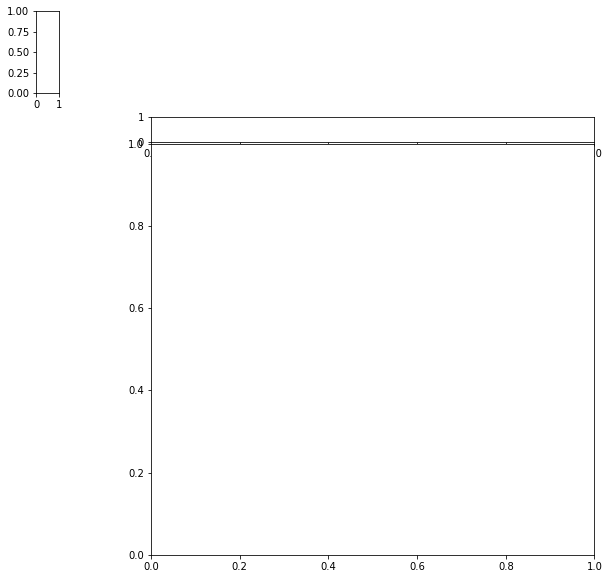

In [19]:
# do some test plotting to inspect the kind of results we get from there...
M_links = linkcandidates.plot_candidates(P_cutoff=0.95, 
                        score_type='likescore', 
                        score_cutoff=0.6, 
                        type='spec-gcf')

#### Show link candidates between GCFs and molecular families
Again done based on "likelihood score", but using metcalf scores gives nearly identical results here.

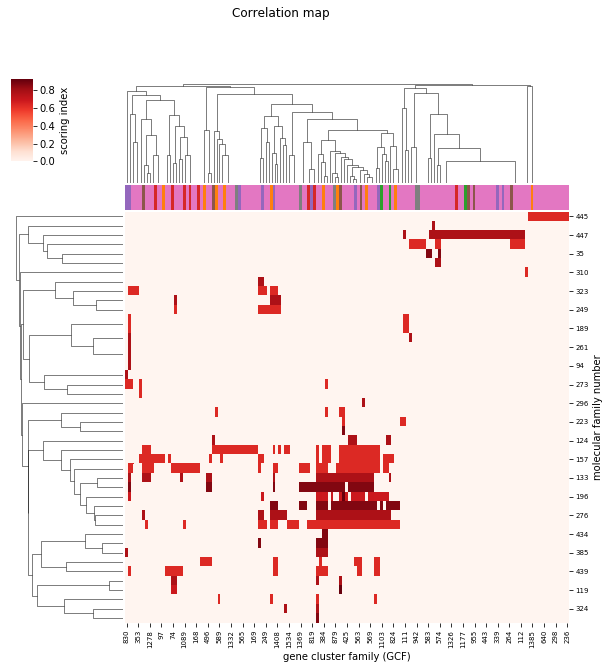

In [14]:
# do some test plotting to inspect the kind of results we get from there...
M_links = linkcandidates.plot_candidates(P_cutoff=0.9, 
                        score_type='likescore', 
                        score_cutoff=0.5, 
                        type='fam-gcf')